In [ ]:
import numpy as np
import pandas as pd

In [336]:
import matplotlib.pyplot as plt

In [337]:
%matplotlib inline

In [ ]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df = df.fillna('NaN')
df_test = df_test.fillna('NaN')

In [ ]:
dates_countries = df.groupby(['Date', 'Country_Region'], as_index=False)\
                    .agg({'ConfirmedCases': 'sum', 'Fatalities': 'sum'})

dates_countries['Date'] = pd.to_datetime(dates_countries['Date'])
training_mask = np.logical_and(pd.to_datetime('2020-01-19') < dates_countries['Date'],
                               dates_countries['Date'] < pd.to_datetime('2020-03-19'))
data = dates_countries[training_mask].copy()
data.loc[:, ('ConfirmedCases', 'Fatalities')] = data.loc[:, ['ConfirmedCases', 'Fatalities']] \
                                                .apply(lambda x: np.log1p(x))
data.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
data.loc[:, ('ConfirmedCases', 'Fatalities')] = data.loc[:, ['ConfirmedCases', 'Fatalities']] \
                                                .apply(lambda x: np.log1p(x))
data.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
def lagging(df, lags=10):
    dfs = []
    for i in range(1, lags):
        lag_df = df.shift(i, fill_value=0)
        lag_df = lag_df.rename(lambda x: x + f'_{i}', axis=1)
        dfs.append(lag_df)
    
    return pd.concat(dfs, axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
data['Day_num'] = le.fit_transform(data.Date)
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month

In [ ]:
country_dfs = []
for country in ['Italy']:#dates_countries['Country_Region'].unique():
    country_mask = data['Country_Region'] == country
    country_df = data.loc[country_mask]
    lags_df = lagging(country_df[['ConfirmedCases', 'Fatalities']])
    country_df = pd.concat([country_df, lags_df], axis=1).dropna()

## ML Brute-force

In [272]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [275]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(model, X, y, n_splits, loss_function):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(X, y):
        start_time = time.time()
        model = model.fit(X[train], y[train])
        fit_time = time.time() - start_time
        
        y_pred = model.predict(X[test])
        y_true = y[test]
        error = loss_function(y_pred, y_true)
        score_time = time.time() - start_time - fit_time
        errors.append(error)
        
        cv_results['train_score'].append()
        cv_results['test_score'].append(error)
    
    res
    return np.mean(np.array(errors))

In [276]:
import seaborn as sns
import math

In [277]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, hinge_loss, f1_score, precision_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [299]:
import warnings
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import tree
import warnings

warnings.filterwarnings("ignore")

In [279]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
# data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
# data_pred.replace([np.inf, -np.inf], 0, inplace=True) 

In [293]:
y_confirmed = country_df['ConfirmedCases'].to_numpy()
y_fatalities = country_df['Fatalities'].to_numpy()
X_train = country_df.drop(columns=['Date', 'Country_Region', 'ConfirmedCases', 'Fatalities'])

In [294]:
print(X_train.shape, y_confirmed.shape)

(57, 22) (57,)


In [347]:
ML_methods = [
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.RandomForestRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
#     linear_model.LogisticRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.Ridge(),
#     linear_model.SGDRegressor(),
#     linear_model.Perceptron(),
#     naive_bayes.BernoulliNB(),
#     naive_bayes.GaussianNB(),
    neighbors.KNeighborsRegressor(),
    svm.SVR(),
    svm.NuSVR(),
    svm.LinearSVR(),
#     discriminant_analysis.LinearDiscriminantAnalysis(),
#     discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ]

ML_columns = ['ML Name', 'ML Parameters','ML Train Error Mean', 'ML Test Error Mean', 'ML Test Error 3*STD' ,'ML Time']
ML_compare = pd.DataFrame(columns = ML_columns)
ML_predict = {}
# rmsle = metrics.mean_squared_log_error
tscv = TimeSeriesSplit(n_splits=3) 

for row_index, clf in tqdm(enumerate(ML_methods)):
    print(f'Training: {clf.__class__.__name__}')
    cv_results = model_selection.cross_validate(clf, X_train, y_confirmed, cv=tscv, scoring='neg_mean_squared_error')

    ML_name = clf.__class__.__name__
    ML_compare.loc[row_index, 'ML Name'] = ML_name
    ML_compare.loc[row_index, 'ML Parameters'] = str(clf.get_params())
    ML_compare.loc[row_index, 'ML Time'] = cv_results['fit_time'].mean()
    ML_compare.loc[row_index, 'ML Train Error Mean'] = -1 * cv_results['train_score'].mean()
    ML_compare.loc[row_index, 'ML Test Error Mean'] = -1 * cv_results['test_score'].mean()   
    ML_compare.loc[row_index, 'ML Test Error 3*STD'] = 3 * cv_results['test_score'].std()

    clf = clf.fit(X_train, y_confirmed)
    ML_predict[ML_name] = clf.predict(X_train)

Training: AdaBoostRegressor
Training: BaggingRegressor
Training: ExtraTreesRegressor
Training: RandomForestRegressor
Training: GradientBoostingRegressor
Training: RandomForestRegressor
Training: PassiveAggressiveRegressor
Training: Ridge
Training: KNeighborsRegressor
Training: SVR
Training: NuSVR
Training: LinearSVR



In [348]:
ML_compare.sort_values(by = ['ML Test Error Mean'], ascending = True, inplace = True)
ML_compare

,ML Name,ML Parameters,ML Train Error Mean,ML Test Error Mean,ML Test Error 3*STD,ML Time
7,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.0184021,0.214056,0.711044,0.00154281
2,ExtraTreesRegressor,"{'bootstrap': False, 'criterion': 'mse', 'max_...",1.09481e-32,0.392585,1.57781,0.0145557
4,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",9.48816e-08,0.393571,1.57706,0.0172546
0,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",1.83371e-05,0.396812,1.56905,0.0219994
5,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.00460279,0.405045,1.5925,0.013897
1,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.0048637,0.406721,1.56812,0.041961
3,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.00309007,0.406936,1.60879,0.01075
8,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.0195362,0.407195,1.54744,0.00184695
11,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.0837308,0.420727,0.996183,0.00237258
10,NuSVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.0087905,1.07681,1.93264,0.00175381


Text(0,0.5,'Algorithm')

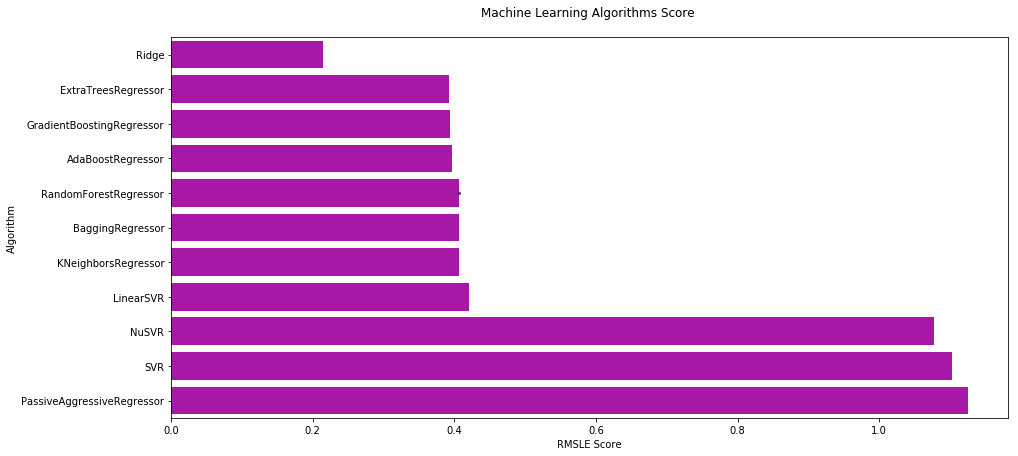

In [349]:
plt.figure(figsize=(15, 7))
sns.barplot(x='ML Test Error Mean', y = 'ML Name', data = ML_compare, color = 'm')
plt.title('Machine Learning Algorithms Score \n')
plt.xlabel('RMSLE Score')
plt.ylabel('Algorithm')